In [1]:
!pip install xmltodict
import torchvision
import xmltodict
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import os
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/kaggle_larxel.zip

In [4]:
!unzip /content/drive/MyDrive/lp_loc.zip

Archive:  /content/drive/MyDrive/lp_loc.zip
   creating: lp_loc/
  inflating: __MACOSX/._lp_loc       
  inflating: lp_loc/.DS_Store        
  inflating: __MACOSX/lp_loc/._.DS_Store  
   creating: lp_loc/images/
  inflating: __MACOSX/lp_loc/._images  
   creating: lp_loc/annotations/
  inflating: __MACOSX/lp_loc/._annotations  
  inflating: lp_loc/images/IMG_1929.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_1929.jpg  
  inflating: lp_loc/images/IMG_1938.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_1938.jpg  
  inflating: lp_loc/images/IMG_1939.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_1939.jpg  
  inflating: lp_loc/images/IMG_8012.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_8012.jpg  
  inflating: lp_loc/images/IMG_7914.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_7914.jpg  
  inflating: lp_loc/images/IMG_1949.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_1949.jpg  
  inflating: lp_loc/images/IMG_8010.jpg  
  inflating: __MACOSX/lp_loc/images/._IMG_8010.jpg  
  inf

In [5]:
import xml.etree.ElementTree as ET
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

def collate_fn(batch):
    images = [item[0] for item in batch]
    boxes = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    # Find the max height and width in the batch
    max_height = max([img.shape[1] for img in images])
    max_width = max([img.shape[2] for img in images])

    # Pad images to the same size
    padded_images = []
    for img in images:
        padded_img = torch.nn.functional.pad(img, (0, max_width - img.shape[2], 0, max_height - img.shape[1]), value=0)
        padded_images.append(padded_img)

    padded_images = torch.stack(padded_images, dim=0)
    return padded_images, boxes, labels

class LicensePlateDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "annotations", self.labels[idx])
        img = Image.open(img_path)

        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        if self.transforms:
            img = self.transforms(img)

        img = img[:3, :, :]
        return img, boxes, labels

    def __len__(self):
        return len(self.imgs)

transform = T.Compose([T.ToTensor()])
dataset = LicensePlateDataset('kaggle_larxel',  transforms=transform)

# Get dataset indices
dataset_size = len(dataset)
indices = list(range(dataset_size))

# Split indices into train, val, and test
train_indices, val_test_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import torch.utils.data
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches


lr = 0.001

# Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the box_predictor with a new one
num_classes = 2  # 1 class (license plate) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to the appropriate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.00005)
# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 50
i = 0
train_precisions = []
train_recalls = []
val_precisions = []
val_recalls = []
train_aps = []
val_aps = []
classification_losses = []
regression_losses = []
for epoch in range(num_epochs):
    for images, boxes, labels in train_loader:
        model.train()
        targets = []
        for box, label in zip(boxes, labels):
            target = {}
            target["boxes"] = box
            target["labels"] = label
            targets.append(target)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        images = images.to(device)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())


        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Access individual losses
        classification_loss = loss_dict['loss_classifier']
        regression_loss = loss_dict['loss_box_reg']

        # Store losses
        classification_losses.append(float(classification_loss)/batch_size)
        regression_losses.append(float(regression_loss)/batch_size)

        print(f"Epoch: {epoch} Iteration: {i}")


        i += 1

        #lr_scheduler.step()
    train_recall, train_precision, train_ap = evaluate_model(model, train_loader, device)
    val_recall, val_precision, val_ap = evaluate_model(model, val_loader, device)

    train_recalls.append(train_recall)
    train_precisions.append(train_precision)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)
    train_aps.append(train_ap)
    val_aps.append(val_ap)
    # Save model checkpoint
    torch.save(model.state_dict(), f"FastRCNN_learning_rate_{lr}_batch_size_{batch_size}_epoch_{epoch}.pth")


# Plot the classification and regression losses
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(classification_losses, label='Classification Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Classification Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regression_losses, label='Regression Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Regression Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_aps, label='Training AP')
plt.plot(val_aps, label='Validation AP')
plt.xlabel('Epoch')
plt.ylabel('Average Precision')
plt.title('Average Precision Over Epochs')
plt.legend()
plt.show()

print("Training complete!")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Iteration: 0
Epoch: 0 Iteration: 1
Epoch: 0 Iteration: 2
Epoch: 0 Iteration: 3
Epoch: 0 Iteration: 4
Epoch: 0 Iteration: 5
Epoch: 0 Iteration: 6
Epoch: 0 Iteration: 7
Epoch: 0 Iteration: 8
Epoch: 0 Iteration: 9
Epoch: 0 Iteration: 10
Epoch: 0 Iteration: 11
Epoch: 0 Iteration: 12
Epoch: 0 Iteration: 13
Epoch: 0 Iteration: 14
Epoch: 0 Iteration: 15
Epoch: 0 Iteration: 16
Epoch: 0 Iteration: 17
Epoch: 0 Iteration: 18
Epoch: 0 Iteration: 19
Epoch: 0 Iteration: 20
Epoch: 0 Iteration: 21
Epoch: 1 Iteration: 22
Epoch: 1 Iteration: 23
Epoch: 1 Iteration: 24
Epoch: 1 Iteration: 25
Epoch: 1 Iteration: 26
Epoch: 1 Iteration: 27
Epoch: 1 Iteration: 28
Epoch: 1 Iteration: 29
Epoch: 1 Iteration: 30
Epoch: 1 Iteration: 31
Epoch: 1 Iteration: 32
Epoch: 1 Iteration: 33
Epoch: 1 Iteration: 34
Epoch: 1 Iteration: 35
Epoch: 1 Iteration: 36
Epoch: 1 Iteration: 37
Epoch: 1 Iteration: 38
Epoch: 1 Iteration: 39
Epoch: 1 Iteration: 40
Epoch: 1 Iteration: 41
Epoch: 1 Iteration: 42
Epoch: 1 Iteration: 4

In [7]:
!pip install mapcalc

In [8]:
import torch
import torchvision
from mapcalc import calculate_map, calculate_map_range

def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.8):
    model.eval()
    correct = 0
    total_pred_boxes = 0
    total_true_boxes = 0
    ground_truth_dict = {"boxes": [], "labels": []}
    result_dict = {"boxes": [], "scores": [], "labels": []}

    with torch.no_grad():
        for images, boxes, labels in data_loader:
            images = [image.to(device) for image in images]
            targets = []
            for box, label in zip(boxes, labels):
                target = {}
                target["boxes"] = box
                target["labels"] = label
                targets.append(target)
                ground_truth_dict["boxes"].extend(box.cpu().numpy())
                ground_truth_dict["labels"].extend(label.cpu().numpy())
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                true_boxes = targets[i]['boxes']

                # Filter out predictions with low scores
                high_score_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[high_score_indices]
                pred_scores = pred_scores[high_score_indices]
                pred_labels = torch.ones_like(pred_scores)

                result_dict["boxes"].extend(pred_boxes.cpu().numpy())
                result_dict["scores"].extend(pred_scores.cpu().numpy())
                result_dict["labels"].extend(pred_labels.cpu().numpy())

                if pred_boxes.nelement() == 0 or true_boxes.nelement() == 0:
                    continue

                iou = torchvision.ops.box_iou(pred_boxes, true_boxes)
                max_iou, _ = iou.max(dim=1)
                correct += (max_iou > iou_threshold).sum().item()
                total_pred_boxes += pred_boxes.size(0)
                total_true_boxes += true_boxes.size(0)


    recall = correct / total_true_boxes if total_true_boxes > 0 else 0
    precision = correct / total_pred_boxes if total_pred_boxes > 0 else 0
    average_precision = calculate_map(ground_truth_dict, result_dict, iou_threshold)


    return recall, precision, average_precision


In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_boxes(img, target):
    fig, ax = plt.subplots(1)
    ax.imshow(img.permute(1, 2, 0).cpu().detach().numpy()) # Convert from (C, H, W) to (H, W, C) for matplotlib

    for i, box in enumerate(target['boxes']):
        if target['scores'][i] > 0.8:
          rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
          ax.add_patch(rect)

    plt.show()


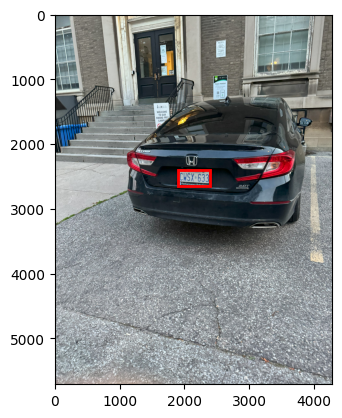

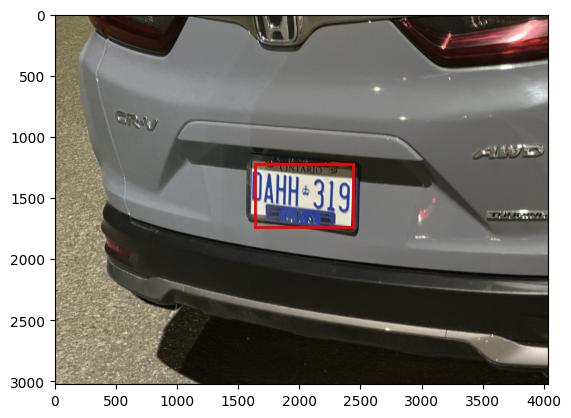

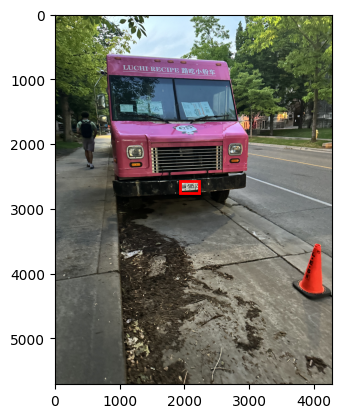

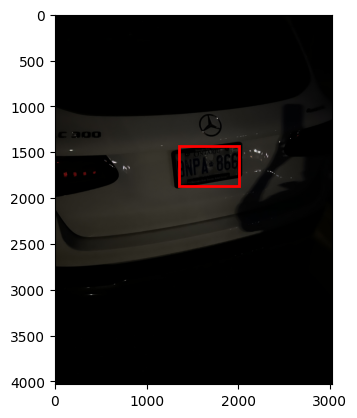

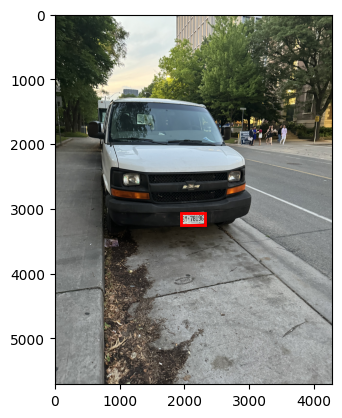

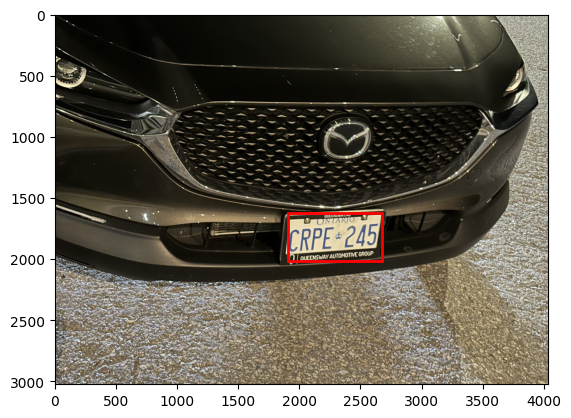

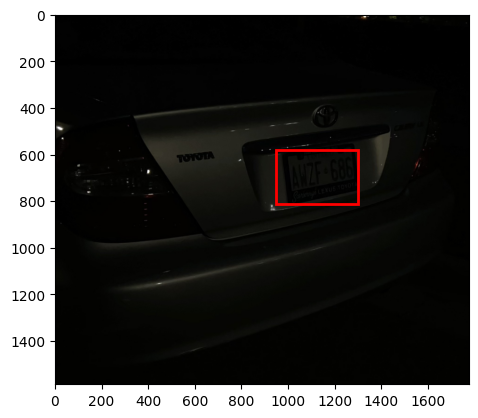

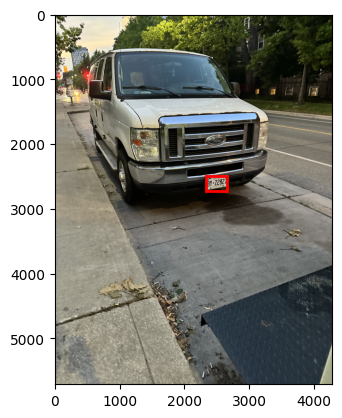

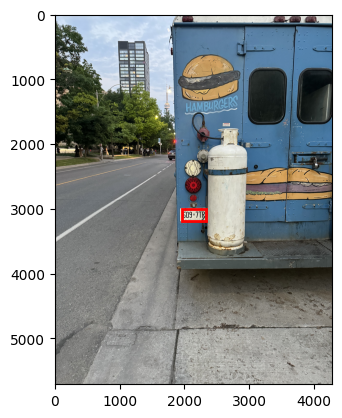

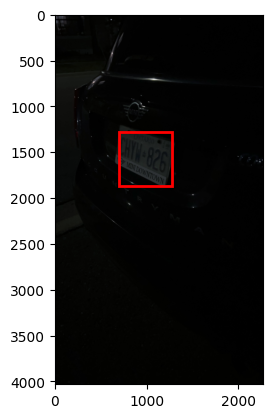

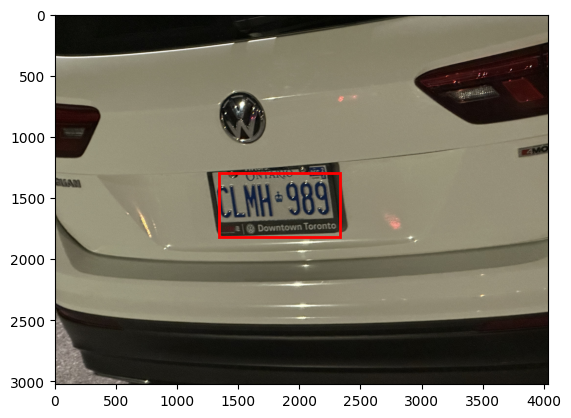

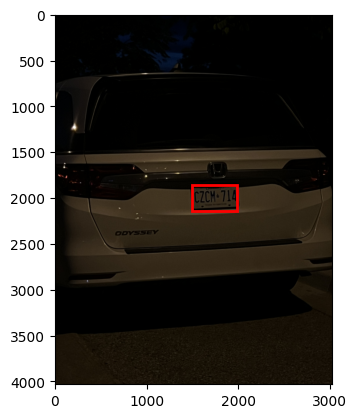

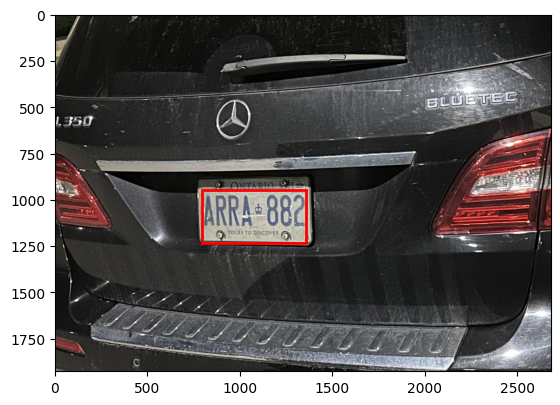

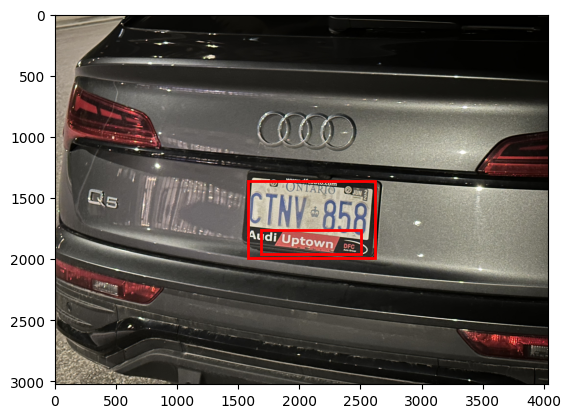

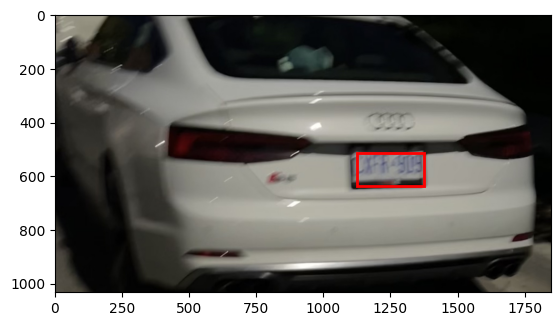

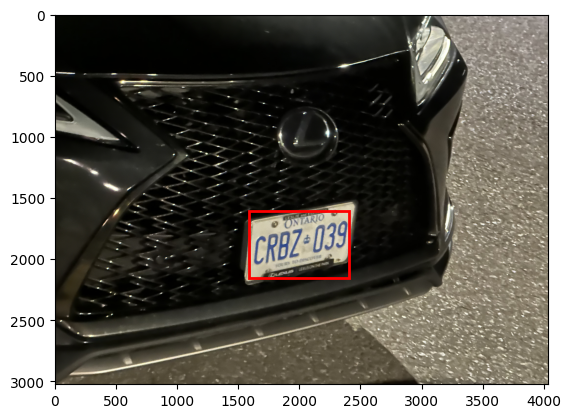

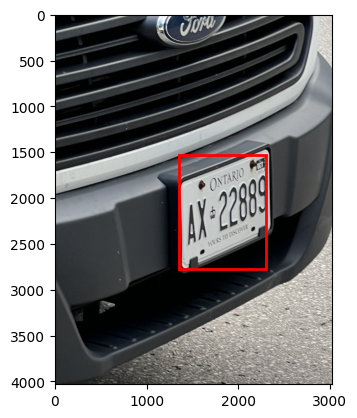

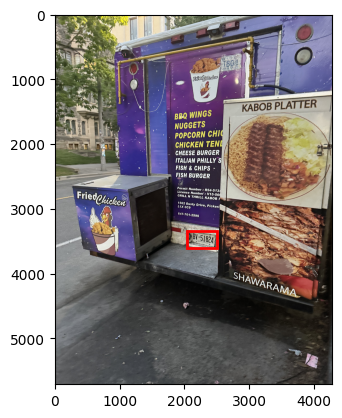

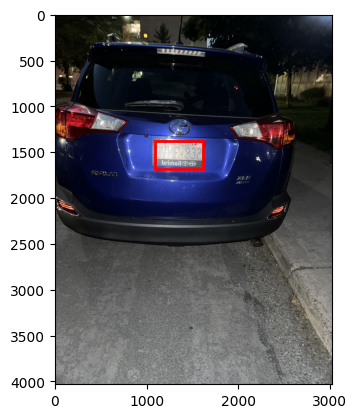

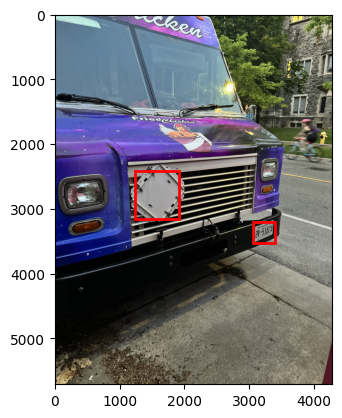

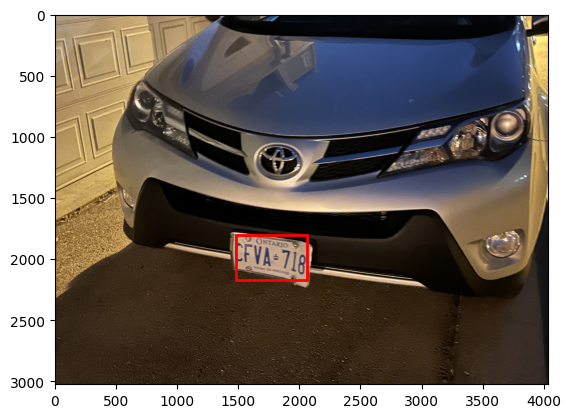

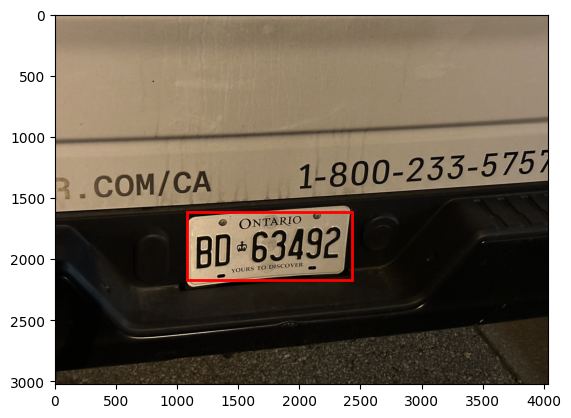

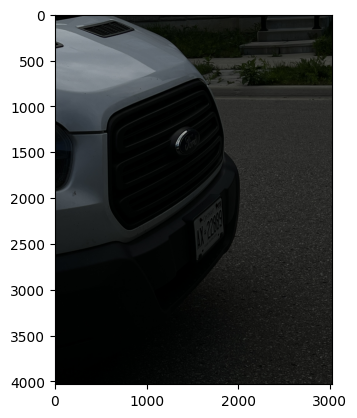

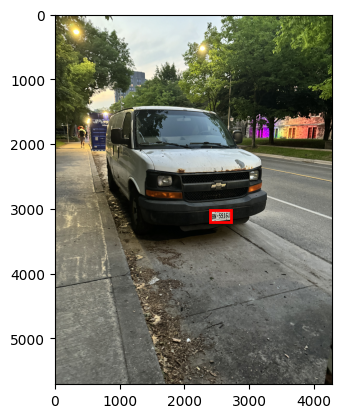

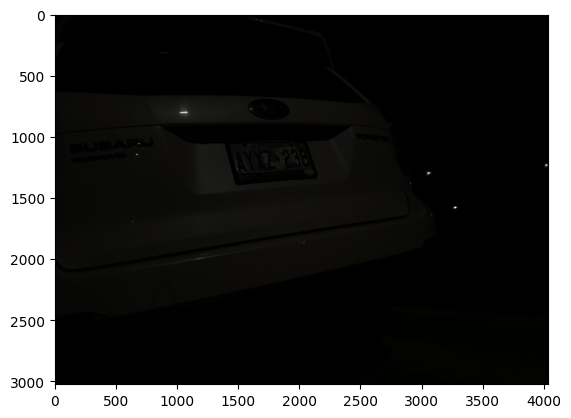

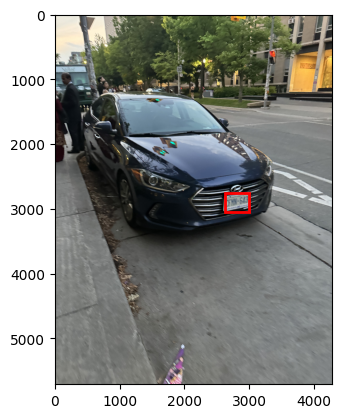

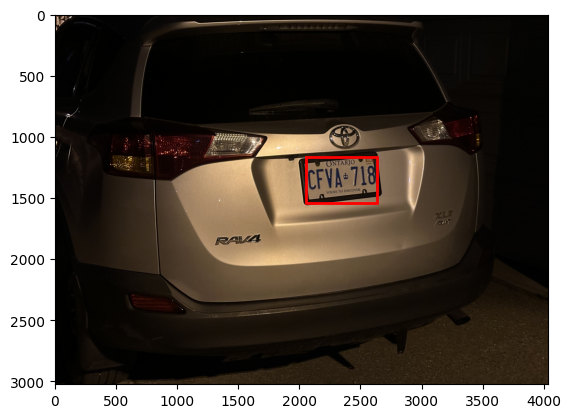

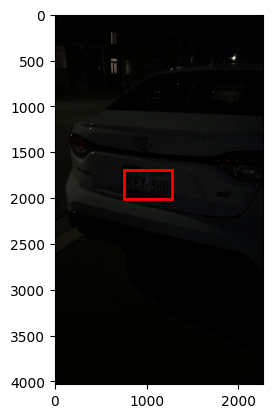

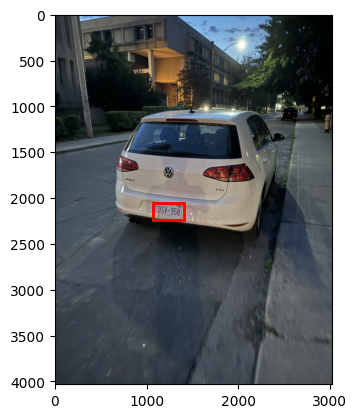

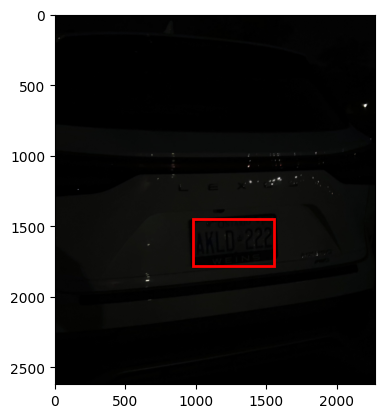

KeyboardInterrupt: 

In [ ]:
model.eval()
model = model.to('cpu')
for images, boxes, labels in new_dataset_loader:
    with torch.no_grad():
        targets = []
        for box, label in zip(boxes, labels):
            target = {}
            target["boxes"] = box
            target["labels"] = label
            targets.append(target)
        images = images[:,:3,:,:]
        pred = model(images)

        visualize_image_with_boxes(images[0], pred[0])


In [ ]:
new_dataset = LicensePlateDataset('lp_loc',  transforms=transform)

new_dataset_loader = DataLoader(new_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
#Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the box_predictor with a new one
num_classes = 2  # 1 class (license plate) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Choose the best model checkpoint based on highest average precision (AP)
max_index = val_aps.index(max(val_aps))
best_model_path = f"FastRCNN_learning_rate_{lr}_batch_size_{batch_size}_epoch_{max_index}.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Move model to the appropriate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Recall, precision, and average precision for the best model on the training set
train_recall, train_precision, train_ap = evaluate_model(model, train_loader, device)
print(f"Training Set - Recall: {train_recall}, Precision: {train_precision}, Average Precision: {train_ap}")

# Recall, precision, and average precision for the best model on the validation set
val_recall, val_precision, val_ap = evaluate_model(model, val_loader, device)
print(f"Validation Set - Recall: {val_recall}, Precision: {val_precision}, Average Precision: {val_ap}")

# Recall, precision, and average precision for the best model on the combined test set
combined_test_set = ConcatDataset([test_dataset, new_dataset])
combined_test_loader = DataLoader(combined_test_set, batch_size=1, shuffle=True, collate_fn=collate_fn)
combined_recall, combined_precision, combined_ap = evaluate_model(model, combined_test_loader, device)
print(f"Combined Test Set - Recall: {combined_recall}, Precision: {combined_precision}, Average Precision: {combined_ap}")

recall, precision, average_precision = evaluate_model(model, new_dataset_loader, device)
print(precision)
print(recall)
print(average_precision)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.8986928104575164
0.919732441471572
0.438672885137674
0.9607843137254902
1.0
0.9379994223548666
